#Setup

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_dir = '/content/drive/MyDrive/Dataset Dr.Fruithy/Apple'

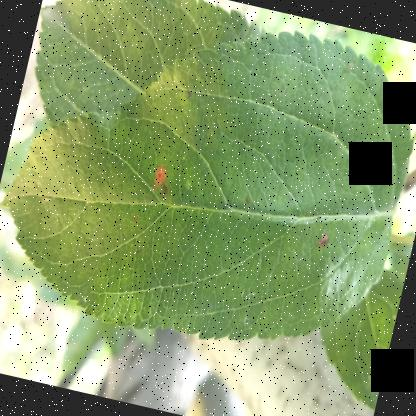

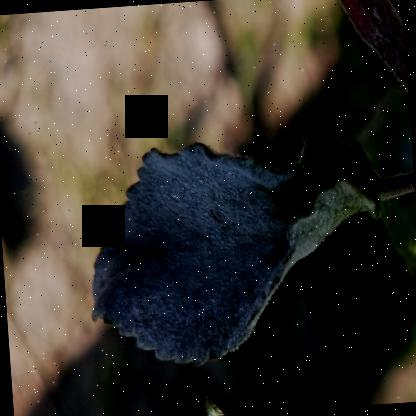

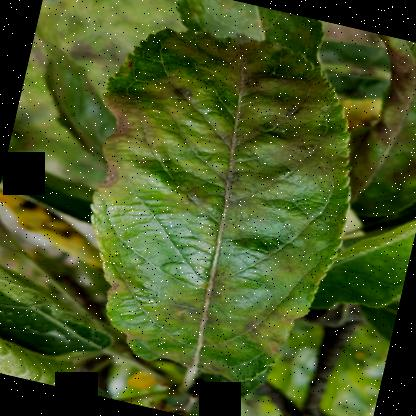

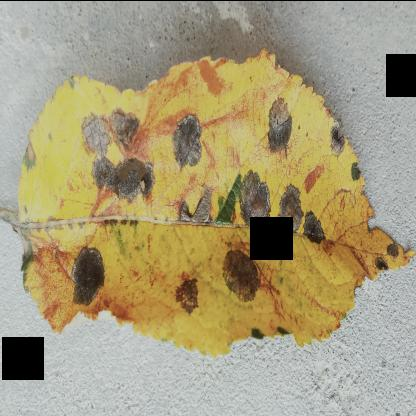

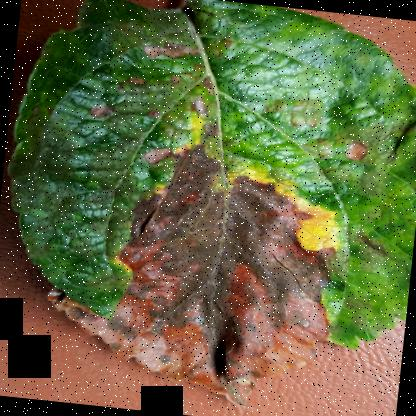

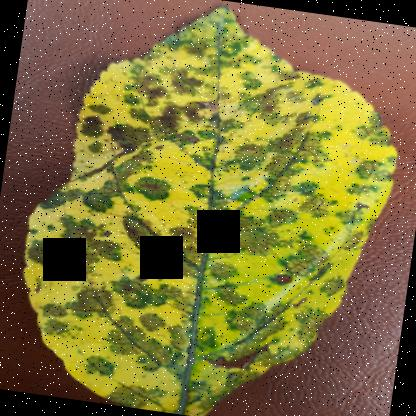

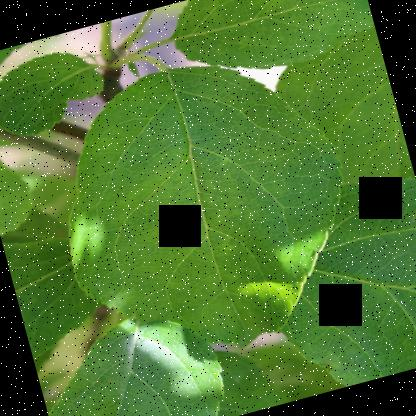

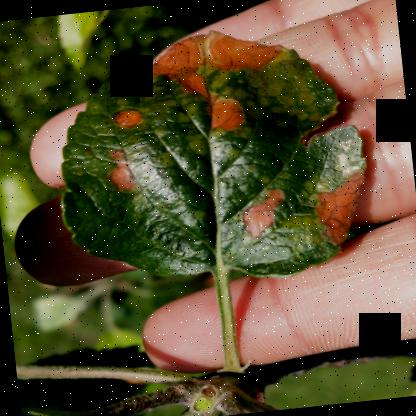

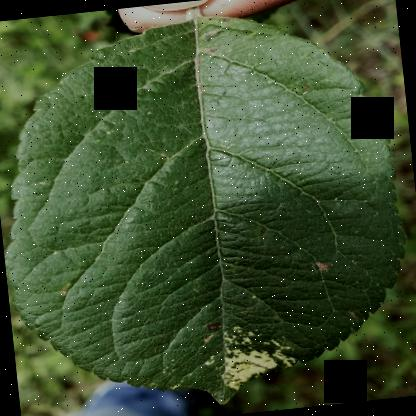

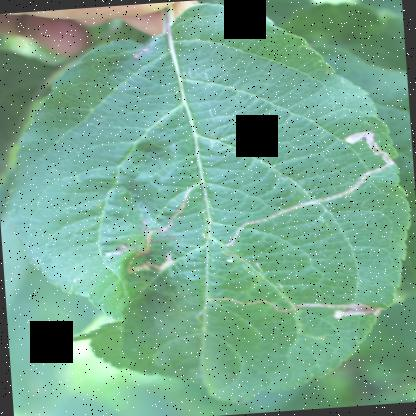

In [4]:
from IPython.display import display, Image, HTML

# melist semua image direktori
folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

# Menampilkan 1 sampel dari setiap folder disease mangga
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:
        sample_image = images[0]
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (240, 320),
    batch_size = 32)

Found 5851 files belonging to 10 classes.


In [6]:
dataset.class_names

['alternaria',
 'demaged',
 'healthy',
 'insect',
 'mlb',
 'mossaic',
 'multiple',
 'necrosis',
 'powdery-mildew',
 'scab']

In [7]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # menegatur
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [8]:
train_ds, val_ds, test_ds = split_dataset(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Data Augmentation

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(240,320),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Build Model

In [11]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [12]:
from tensorflow.keras.optimizers import Adam
resize_and_rescale,
data_augmentation,

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(240, 320, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten layer
  tf.keras.layers.Flatten(),

  # Add fully connected layers with dropout and regularization
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 240, 320, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 160, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 120, 160, 128)     512       
 chNormalization)                                                
                                                      

# Model Train

In [15]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
146/146 [==============================] - 297s 284ms/step - loss: 4.0207 - accuracy: 0.3634 - val_loss: 2.5121 - val_accuracy: 0.4062
Epoch 2/20
146/146 [==============================] - 33s 224ms/step - loss: 2.3502 - accuracy: 0.4623 - val_loss: 2.0008 - val_accuracy: 0.5712
Epoch 3/20
146/146 [==============================] - 33s 225ms/step - loss: 2.2075 - accuracy: 0.4878 - val_loss: 1.8543 - val_accuracy: 0.5903
Epoch 4/20
146/146 [==============================] - 32s 222ms/step - loss: 1.9796 - accuracy: 0.5449 - val_loss: 1.7058 - val_accuracy: 0.6233
Epoch 5/20
146/146 [==============================] - 33s 224ms/step - loss: 1.7933 - accuracy: 0.6006 - val_loss: 1.5757 - val_accuracy: 0.6632
Epoch 6/20
146/146 [==============================] - 33s 223ms/step - loss: 1.6729 - accuracy: 0.6295 - val_loss: 1.4719 - val_accuracy: 0.6927
Epoch 7/20
146/146 [==============================] - 33s 223ms/step - loss: 1.5494 - accuracy: 0.6659 - val_loss: 1.4631 - val_a

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

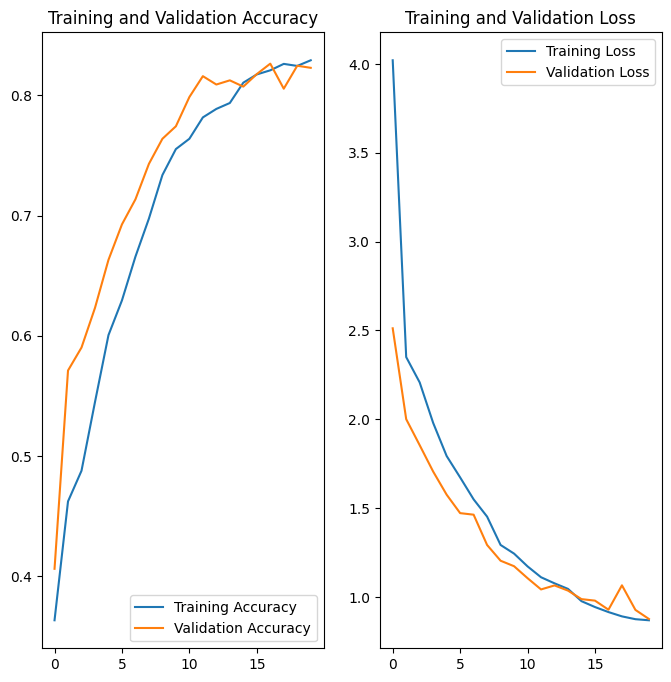

In [30]:
EPOCHS = 20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Prediction

In [34]:
class_names = dataset.class_names
class_names

['alternaria',
 'demaged',
 'healthy',
 'insect',
 'mlb',
 'mossaic',
 'multiple',
 'necrosis',
 'powdery-mildew',
 'scab']

first image to predict
actual label: healthy
1/1 [==============================] - 0s 50ms/step
predicted label: healthy


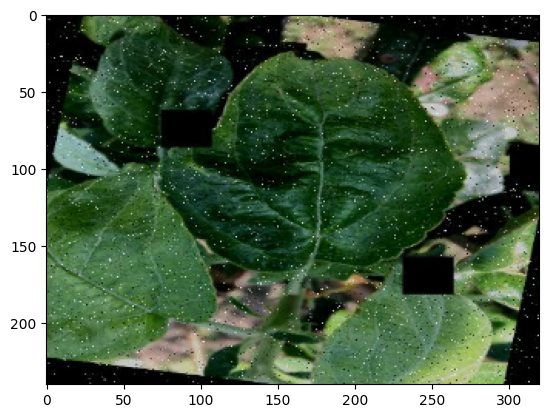

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


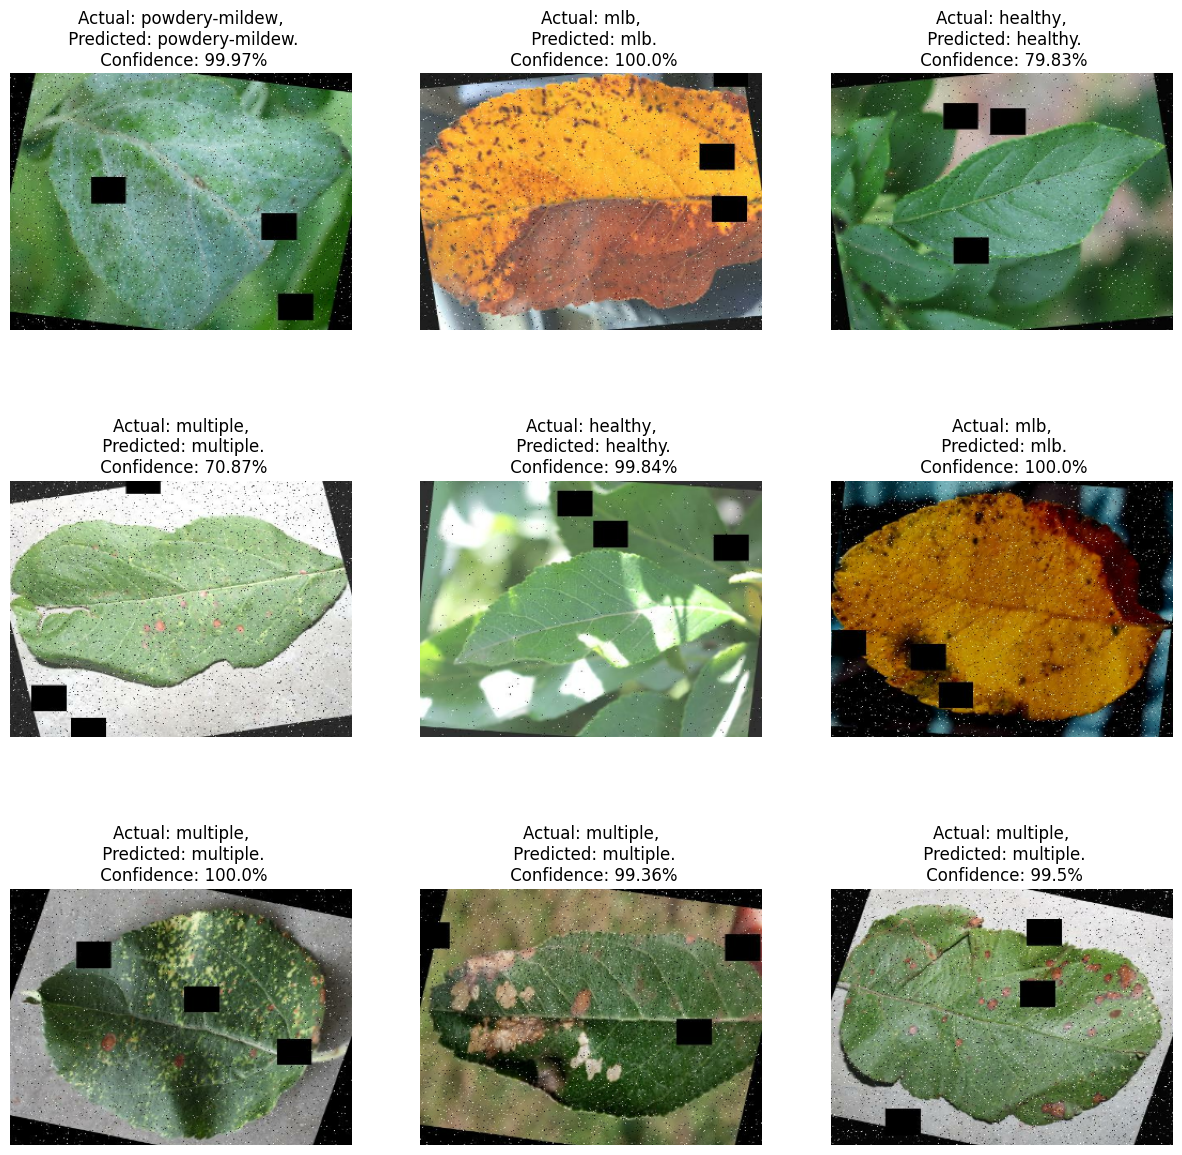

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Export Model

In [16]:
model.save('/saved_model_apple', save_format='tf')

In [17]:
import os

# List all files and directories in the root directory
for root, dirs, files in os.walk('/saved_model_apple'):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

/saved_model_apple/saved_model.pb
/saved_model_apple/fingerprint.pb
/saved_model_apple/keras_metadata.pb
/saved_model_apple/assets
/saved_model_apple/variables
/saved_model_apple/variables/variables.data-00000-of-00001
/saved_model_apple/variables/variables.index


In [22]:
from google.colab import files

# Path to the directory you want to archive
directory_to_zip = '/saved_model_apple'

# Path and name for the output zip file
output_filename = '/content/saved_model_apple.zip'

# Create a zip archive
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# Download the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>